In [1]:
import pandas as pd
import numpy as np
import keras
from keras.layers import Dense, Input, LSTM, concatenate, Embedding
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import gc
import matplotlib.pyplot as plt
import os
import csv
from datetime import datetime
from log import _check_log_directory,_initialise_model_log
from operator import itemgetter
from keras.utils import plot_model
import pickle
from load_features import load_features
from nltk.corpus import stopwords

/Users/Michael/Library/Python/2.7/lib/python/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data_dir = "data/"
log_dir = './log'

In [3]:
features_train, features_test, data_train = load_features(data_dir)
data_test = pd.read_csv(data_dir+'test.csv', sep=',',names = ["id", "qid1", "qid2", "question1","question2","is_duplicate"])

In [4]:
X = features_train.drop(['is_duplicate'],axis=1)
X_test = features_test
X = X.replace([np.inf, -np.inf], np.nan)
X = X .fillna(value=0)
X_test=X_test.replace([np.inf, -np.inf], np.nan)
X_test=X_test.fillna(value=0)
Y = data_train["is_duplicate"].values

In [5]:
X.columns

Index([      u'len_q1',       u'len_q2',     u'diff_len',  u'len_char_q1',
        u'len_char_q2',  u'len_word_q1',  u'len_word_q2', u'common_words',
        u'fuzz_qratio',  u'fuzz_WRatio',
       ...
           u'num_w_q1',     u'num_w_q2',     u'num_v_q1',     u'num_v_q2',
           u'num_y_q1',     u'num_y_q2',     u'num_x_q1',     u'num_x_q2',
           u'num_z_q1',     u'num_z_q2'],
      dtype='object', length=158)

# Fully connected

In [6]:
data = X
test_size = 0.1
X_train, X_val, Y_train, Y_val = train_test_split(data, Y, test_size=test_size)
del data
gc.collect()

575

In [7]:
number_of_features = X.values.shape[1]
print "number of features =", number_of_features

number of features = 158


## First training phase 

In [8]:
X_train_np = X_train.values
X_val_np = X_val.values
Y_train_np = Y_train
Y_val_np  = Y_val

shape = (X_train_np.shape[1],)
model = Sequential()
model.add(Dense(1024, activation='sigmoid',input_shape=shape))
model.add(Dense(1,activation = "sigmoid"))
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt)


weights_path = os.path.join(data_dir,'weights_1hidden_layer')
weights_path_best = weights_path + ".best.h5"
weights_path_last = weights_path + ".last.h5"
checkpoint_best = ModelCheckpoint(weights_path_best, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
checkpoint_last = ModelCheckpoint(weights_path_last, verbose=1, save_weights_only=True, period=2)
callbacks = [checkpoint_best,checkpoint_last]
history = model.fit(X_train_np,Y_train_np,epochs=2,validation_data =(X_val_np,Y_val_np),callbacks=callbacks)

Train on 72090 samples, validate on 8010 samples
Epoch 1/2
72090/72090 [==============================] - 20s 282us/step - loss: 0.4965 - val_loss: 0.3583
Epoch 2/2
71872/72090 [============================>.] - ETA: 0s - loss: 0.2925Epoch 00002: val_loss improved from 0.35831 to 0.25485, saving model to data/weights_1hidden_layer.best.h5
Epoch 00002: saving model to data/weights_1hidden_layer.last.h5
72090/72090 [==============================] - 16s 221us/step - loss: 0.2925 - val_loss: 0.2548


## Second training phase 

In [9]:
opt = keras.optimizers.Adam(lr=0.00001)
model.compile(loss='binary_crossentropy', optimizer=opt)
history2 = model.fit(X_train_np,Y_train_np,epochs=2,validation_data =(X_val_np,Y_val_np),callbacks=callbacks)

Train on 72090 samples, validate on 8010 samples
Epoch 1/2
72090/72090 [==============================] - 18s 252us/step - loss: 0.2315 - val_loss: 0.2322
Epoch 2/2
72064/72090 [============================>.] - ETA: 0s - loss: 0.2217Epoch 00002: val_loss improved from 0.23220 to 0.22394, saving model to data/weights_1hidden_layer.best.h5
Epoch 00002: saving model to data/weights_1hidden_layer.last.h5
72090/72090 [==============================] - 23s 322us/step - loss: 0.2217 - val_loss: 0.2239


## Plot loss 

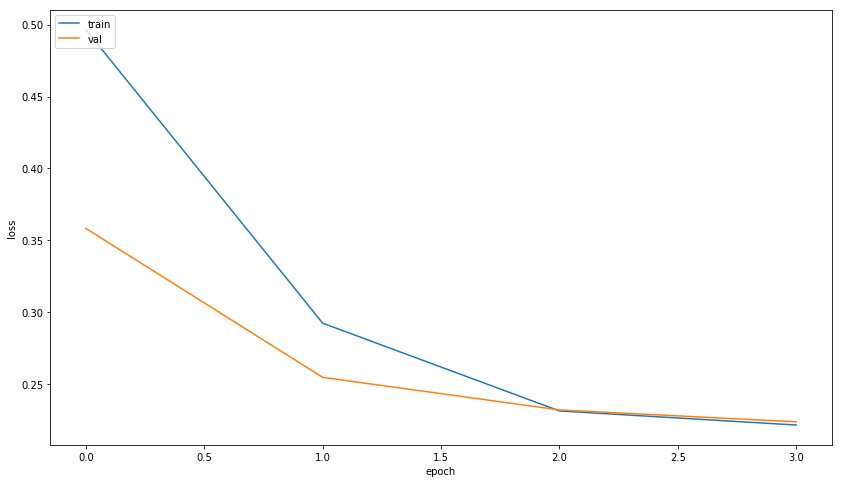

In [10]:
plt.rcParams["figure.figsize"] = (14,8)
plt.plot(history.history["loss"]+history2.history["loss"])
plt.plot(history.history["val_loss"]+history2.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

## Load best model and predict

In [11]:
model.load_weights(weights_path_best)
pred = model.predict([X_test])

## save result in csv

In [12]:
df_pred = pd.DataFrame(pred)
df_pred.index = X_test.index
df_pred.columns = ["Score"]
df_pred.to_csv("data/submission_file_FCNN_1hidden1024_99features_0,21.csv",index_label="Id")
df_pred.describe()

,Score
count,20179.000000
mean,0.633585
std,0.384509
min,0.070447
25%,0.191852
50%,0.942075
75%,0.967982
max,0.999991


# LSTM

In [13]:
data_test = pd.read_csv(data_dir+'test.csv', sep=',',names = ["id", "qid1", "qid2", "question1","question2","is_duplicate"])
remove_stopwords = True

## Calcul de la taille maximale des questions

In [14]:
q1_train = data_train["question1"]
q2_train = data_train["question2"]
q1_test = data_test["question1"]
q2_test = data_test["question2"]

In [15]:
q1_train_sp = [q.lower().replace('?','').split() for q in q1_train]
q2_train_sp = [q.lower().replace('?','').split() for q in q2_train]
q1_test_sp = [q.lower().replace('?','').split() for q in q1_test]
q2_test_sp = [q.lower().replace('?','').split() for q in q2_test]

if remove_stopwords:
    stop_words = stopwords.words('english')
    q1_train_sp = [[w for w in q if w not in stop_words ] for q in q1_train_sp]
    q2_train_sp = [[w for w in q if w not in stop_words ] for q in q2_train_sp]
    q1_test_sp =  [[w for w in q if w not in stop_words ] for q in q1_test_sp]
    q2_test_sp =  [[w for w in q if w not in stop_words ] for q in q2_test_sp]

/Users/Michael/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:8: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  
/Users/Michael/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:9: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if __name__ == '__main__':
/Users/Michael/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:10: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  # Remove the CWD from sys.path while we load stuff.
/Users/Michael/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:11: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  # This is added back by InteractiveShellApp.init_path()


In [16]:
m1 =  max([len(q) for q in q1_train_sp])
m2 =  max([len(q) for q in q2_train_sp])
m3 =  max([len(q) for q in q1_test_sp])
m4 =  max([len(q) for q in q2_test_sp])
print m1,m2,m3,m4

29 27 36 22


In [17]:
seq_length = max([m1,m2,m3,m4]) # maximum word per question 

In [18]:
words = {}
for i in range(len(q1_train_sp)):
    for q in q1_train_sp[i]:
        if q in words:
            words[q] += 1
        else:
            words[q] = 1
for i in range(len(q2_train_sp)):
    for q in q2_train_sp[i]:
        if q in words:
            words[q] += 1
        else:
            words[q] = 1
            
sorted_words = sorted(words.items(),key=itemgetter(1), reverse=True)
words_index ={}
for num,couple in enumerate(sorted_words):
    words_index[couple[0]] = num + 1

num_words = len(sorted_words)
print "Nombre de mot dans le vocabulaire de train :",num_words

def get_index(word,vocab):
    if word in vocab:
        return vocab[word]
    return 0
q1_train_sp_ind = [ [get_index(word,words_index) for word in sentence] for sentence in q1_train_sp]
q2_train_sp_ind = [ [get_index(word,words_index) for word in sentence] for sentence in q2_train_sp]
q1_test_sp_ind = [ [get_index(word,words_index) for word in sentence] for sentence in q1_test_sp]
q2_test_sp_ind = [ [get_index(word,words_index) for word in sentence] for sentence in q2_test_sp]

Nombre de mot dans le vocabulaire de train : 22926


In [19]:
q1_train_sp_ind_pad = sequence.pad_sequences(q1_train_sp_ind, maxlen=seq_length,padding='post')
q2_train_sp_ind_pad = sequence.pad_sequences(q2_train_sp_ind, maxlen=seq_length,padding='post')
q1_test_sp_ind_pad = sequence.pad_sequences(q1_test_sp_ind, maxlen=seq_length,padding='post')
q2_test_sp_ind_pad = sequence.pad_sequences(q2_test_sp_ind, maxlen=seq_length,padding='post')

In [21]:
test_size = 0.1
q1_train,q1_val,q2_train,q2_val,X_train,X_val,Y_train,Y_val = train_test_split(q1_train_sp_ind_pad,q2_train_sp_ind_pad,X,Y, test_size=test_size)

# Without features

In [22]:
embedding_dim = 300 # embeding size
dropout_rate = 0.5

lstm_input1 = Input(shape=(seq_length,), name='lstm_input1')
lstm_input2 = Input(shape=(seq_length,), name='lstm_input2')

E_layer = Embedding(num_words, embedding_dim, weights=None, input_length=seq_length, trainable=True,mask_zero=True)
emb1 = E_layer(lstm_input1)
emb2 = E_layer(lstm_input2)

lstm_layer = LSTM(units=512,dropout=dropout_rate)
lstm1 = lstm_layer(emb1)
lstm2 = lstm_layer(emb2)
x = concatenate([lstm1,lstm2])
x = Dense(1024, activation='sigmoid')(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=[lstm_input1,lstm_input2],outputs=x)

In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_input1 (InputLayer)        (None, 36)           0                                            
__________________________________________________________________________________________________
lstm_input2 (InputLayer)        (None, 36)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 36, 300)      6877800     lstm_input1[0][0]                
                                                                 lstm_input2[0][0]                
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 512)          1665024     embedding_1[0][0]                
          

In [24]:
plot_model(model,to_file='model_lstm.png')

In [ ]:
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt)
weights_path = os.path.join(data_dir,'weights_LSTM')
weights_path_best = weights_path + ".best.h5"
weights_path_last = weights_path + ".last.h5"
checkpoint_best = ModelCheckpoint(weights_path_best, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
checkpoint_last = ModelCheckpoint(weights_path_last, verbose=1, save_weights_only=True, period=2)
callbacks = [checkpoint_best,checkpoint_last]
history = model.fit([q1_train,q2_train],Y_train,epochs=3,validation_data =([q1_val,q2_val],Y_val),callbacks=callbacks)

# LSTM + features

In [26]:
embedding_dim = 300 # embeding size
dropout_rate = 0.5

lstm_input1 = Input(shape=(seq_length,), name='lstm_input1')
lstm_input2 = Input(shape=(seq_length,), name='lstm_input2')
input_features = Input(shape=(number_of_features,), name='input_features')

E_layer = Embedding(num_words, embedding_dim, weights=None, input_length=seq_length, trainable=True,mask_zero=True)
emb1 = E_layer(lstm_input1)
emb2 = E_layer(lstm_input2)

lstm_layer = LSTM(units=512,dropout=dropout_rate)
lstm1 = lstm_layer(emb1)
lstm2 = lstm_layer(emb2)
x = concatenate([lstm1,lstm2,input_features])
x = Dense(1024, activation='sigmoid')(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=[lstm_input1,lstm_input2,input_features],outputs=x)

In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_input1 (InputLayer)        (None, 36)           0                                            
__________________________________________________________________________________________________
lstm_input2 (InputLayer)        (None, 36)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 36, 300)      6877800     lstm_input1[0][0]                
                                                                 lstm_input2[0][0]                
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 512)          1665024     embedding_2[0][0]                
          

In [28]:
plot_model(model,to_file='model_lstm_features.png')

In [ ]:
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt)
weights_path = os.path.join(data_dir,'weights_LSTM_features')
weights_path_best = weights_path + ".best.h5"
weights_path_last = weights_path + ".last.h5"
checkpoint_best = ModelCheckpoint(weights_path_best, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
checkpoint_last = ModelCheckpoint(weights_path_last, verbose=1, save_weights_only=True, period=2)
callbacks = [checkpoint_best,checkpoint_last]
history = model.fit([q1_train,q2_train,X_train],Y_train,epochs=3,validation_data =([q1_val,q2_val,X_val],Y_val),callbacks=callbacks)

Index([u'is_duplicate',       u'len_q1',       u'len_q2',     u'diff_len',
        u'len_char_q1',  u'len_char_q2',  u'len_word_q1',  u'len_word_q2',
       u'common_words',  u'fuzz_qratio',
       ...
           u'num_w_q1',     u'num_w_q2',     u'num_v_q1',     u'num_v_q2',
           u'num_y_q1',     u'num_y_q2',     u'num_x_q1',     u'num_x_q2',
           u'num_z_q1',     u'num_z_q2'],
      dtype='object', length=159)

In [ ]:
## Apres ici ce sont des tests

In [113]:
q2_test_sp_ind[:5]

[[2, 4, 1, 14, 1060, 2846, 488],
 [3, 11, 5, 108, 295, 527],
 [2, 4, 1, 14, 37, 6, 222, 24, 491],
 [18, 4, 17, 118, 3217, 409, 597, 1196, 12, 1358],
 [2, 4, 1, 14, 37, 6, 269, 41, 342, 599]]

In [123]:
truc = np.hstack([q1_train_sp_ind_pad,q2_train_sp_ind_pad])
print truc.shape
print truc[:2]

(80100, 146)
[[   2    9    1   20   12    1   14 1538    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    2    9   20   12    1  851 1538   12  101   60   18
     9  103  476    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   2    9    1  662   29  297   16  384 2366    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0  

In [34]:
data_test

,qid2,question1,question2,is_duplicate
qid1,,,,
0,245776,2705,What are the best sites to book a hotel online?,What is the best hotel booking service?
1,104796,48346,How can I stop masturbation?,How can I stop doing masturbation?
2,41770,383018,Which is the best way to control anger?,What is the best way to control your anger?
3,81132,401393,Why is my Miniature Pinscher/Chihuahua mix afr...,Why is my Black Lab/Pitbull mix puppy afraid o...
4,244572,7520,How do I get rid off from porn addiction?,What is the best way to overcome an porn addic...
5,436197,287812,What is the easiest way to learn how to draw?,How do I learn how to draw?
6,61578,451982,What secret can you not share with anyone?,What is the one secret you can never share wit...
7,134731,120381,How can I improve my vocabulary?,What are some good ways to improve English voc...
8,383155,74916,How do I calculate square roots and cubed root...,What is the method to calculate a square root ...


# Load features 

In [33]:
features_train = pd.read_csv('data/train_features_glove.csv', sep=',', encoding='latin-1')
features_test = pd.read_csv('data/test_features_glove.csv', sep=',', encoding='latin-1')
data_train = pd.read_csv('train.csv', sep=',',names = ["id", "qid1", "qid2", "question1","question2","is_duplicate"])
Y = data_train.pop("is_duplicate")

In [34]:
X = features_train
X_test = features_test
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(value=0)
X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_test = X_test.fillna(value=0)

In [35]:
data = X
#data.pop("question1")
#data.pop("question2")
#data.pop("is_duplicate")
X_train= features_train.drop(['question1','question2','is_duplicate','cosine_distance','jaccard_distance','euclidean_distance','norm_wmd','fuzz_WRatio','len_word_q2','len_word_q1','minkowski_distance','braycurtis_distance'], axis=1)
test_size = 0.1
X_train, X_val, Y_train, Y_val = train_test_split(data, Y, test_size=test_size)
del data
gc.collect()

45

In [39]:
import keras
X_train_np = X_train.values
X_val_np = X_val.values
Y_train_np = Y_train.values
Y_val_np  = Y_val.values

shape = (X_train_np.shape[1],)
model = Sequential()
model.add(Dense(1024, activation='sigmoid',input_shape=shape))
model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(1024, activation='sigmoid'))
#model.add(Dense(1024, activation='tanh'))
model.add(Dense(1,activation = "sigmoid"))
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer="adam")
model.fit(X_train_np,Y_train_np,nb_epoch=10,validation_data =(X_val_np,Y_val_np))

Train on 72090 samples, validate on 8010 samples
Epoch 1/10
72090/72090 [==============================] - 273s 4ms/step - loss: 0.5719 - val_loss: 0.5572
Epoch 2/10
72090/72090 [==============================] - 162s 2ms/step - loss: 0.5489 - val_loss: 0.5507
Epoch 3/10
72090/72090 [==============================] - 157s 2ms/step - loss: 0.5407 - val_loss: 0.5414
Epoch 4/10
72090/72090 [==============================] - 157s 2ms/step - loss: 0.5368 - val_loss: 0.5550
Epoch 5/10
72090/72090 [==============================] - 158s 2ms/step - loss: 0.5318 - val_loss: 0.5314
Epoch 6/10
72090/72090 [==============================] - 169s 2ms/step - loss: 0.5290 - val_loss: 0.5328
Epoch 7/10
72090/72090 [==============================] - 288s 4ms/step - loss: 0.5247 - val_loss: 0.5434
Epoch 8/10
72090/72090 [==============================] - 358s 5ms/step - loss: 0.5230 - val_loss: 0.5263
Epoch 9/10
72090/72090 [==============================] - 414s 6ms/step - loss: 0.5204 - val_loss: 0.53

In [37]:
X_train.head()

,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzz_qratio,fuzz_WRatio,...,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
61470,30,26,4,15,13,6,5,2,67,70,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-5.397956,-5.397956,50.999782,50.999782
52652,115,39,76,23,16,25,9,6,38,86,...,6.248636,1.0,157.564608,0.454233,0.206826,0.378103,-7.113229,-4.746818,65.892186,38.016010
62647,104,99,5,23,27,16,16,6,62,62,...,6.700246,1.0,160.466555,0.477150,0.213258,0.390585,-5.871459,-4.239369,46.448806,28.991935
605,38,42,-4,15,16,7,7,3,79,79,...,11.052061,1.0,166.510503,0.815223,0.377213,0.485439,-0.580091,-2.302947,1.765170,14.246697
5464,43,35,8,20,16,8,7,2,58,58,...,8.190089,1.0,153.197744,0.605530,0.279310,0.394413,-3.854237,-2.359391,31.850361,19.318841


In [30]:
X_train.head()

,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,...,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
19866,What is a good way to spend a long weekend in ...,What is the best way to spend a weekend in Ban...,1,67,53,14,20,20,14,11,...,3.778034,1.0,128.590874,0.273035,0.124839,0.236917,-6.923558,-6.190262,63.793805,53.960178
38013,What does it mean if a dog vomits white foam?,What does it mean if a dog is throwing up yell...,1,45,77,-32,16,23,10,17,...,6.219466,1.0,147.157158,0.445947,0.200436,0.341283,-3.553175,-4.978099,25.958704,42.166227
60509,How can you make your skin lighter?,What can I do to make my skin whiter?,1,35,37,-2,19,18,7,9,...,6.720695,1.0,137.431993,0.473985,0.210055,0.325232,-4.250795,-2.831428,34.080928,20.905081
73053,What is the best passive investment strategy?,What is your investment strategy?,0,45,33,12,16,16,7,5,...,5.982412,1.0,137.046347,0.435726,0.200231,0.304307,-5.354166,-3.369078,46.089431,23.742220
56738,What is the best way to start learning program...,How do I start learning programming language? ...,1,71,70,1,21,21,12,12,...,4.675204,1.0,143.059820,0.340347,0.155126,0.297584,-6.921454,-6.508542,65.565907,58.963952


In [34]:
Y = data_train['is_duplicate']
test_size = 0.1
q1_train, q1_val, q2_train, q2_val, Y_train, Y_val = train_test_split(q1_train_sp_ind_pad,q2_train_sp_ind_pad, Y, test_size=test_size)

In [35]:
q1_train

array([[  84,  145,  142, ...,    0,    0,    0],
       [  29, 1461, 1048, ...,    0,    0,    0],
       [  84,  145,  142, ...,    0,    0,    0],
       ...,
       [ 508,    5, 6745, ...,    0,    0,    0],
       [ 363,  248, 3036, ...,    0,    0,    0],
       [ 654,  533,   20, ...,    0,    0,    0]], dtype=int32)